# Analysis & Graph Visualizations

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np
import random as rm
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles

## Subset of citations

In [2]:
all_citations = pd.read_csv('../inputdata/all_cases_citations.csv')
print('Total citations relations EUR-LEX: ',len(all_citations))

Total citations relations EUR-LEX:  43780


In [3]:
sampled_cases = pd.read_csv('../inputdata/sampled_cases.csv').rename(columns={'source':'case'})
print('Total sampled cases for the study: ',len(sampled_cases))

Total sampled cases for the study:  177


In [4]:
sampled_cases.head()

,quantile,case,citations,source_case_topic
0,1.00,61990CJ0006,43,social policy
1,1.00,62003CJ0453,32,public health
2,0.99,62007CJ0378,32,social policy
3,0.98,61995CJ0261,19,social policy
4,1.00,62000CJ0465,17,data protection


In [5]:
print(
len(sampled_cases[sampled_cases['source_case_topic']=='social policy']),
len(sampled_cases[sampled_cases['source_case_topic']=='public health']),
len(sampled_cases[sampled_cases['source_case_topic']=='data protection'])
)


85 63 29


---
## Functions 

In [6]:
#Creating all unique nodes of the graph (this nodes catakogue works for both graphs)
def df_to_json_nodes(df_relations, df_attributes, node_name = 'case'):
    """"Assumes the columns are called source and target"""
    nodes_list = []; nodes = pd.DataFrame()
    nodes_list.extend(list(df_relations.source))# .unique()))
    nodes_list.extend(list(df_relations.target))# .unique()))
    nodes[str(node_name)] = list(set(nodes_list))  # DataFrame index must be unique for orient='index'.
    nodes = pd.merge(nodes, df_attributes, how='left').fillna('NA')
    nodes = nodes.set_index(str(node_name)).to_dict('index')
    return nodes

In [7]:
#Get the graph and layout, works only for this dataset
def graph_and_layout(df, nodes):
    #Assumes the relations are called source and target
    g = nx.from_pandas_edgelist(df, 'source', 'target', edge_attr=True) #, create_using = nx.DiGraph)
    nx.set_node_attributes(g, nodes)
    return g

In [8]:
#Graph description
def graph_description(g):
    N_nodes, N_edges = g.order(), g.size()
    avg_deg = float(N_nodes)/N_edges
    print ('Nodes: {}\nEdges: {}\nAvg Degree: {}'.format(N_nodes, N_edges, avg_deg) )

In [9]:
#goupings the colors
def groups(g):
    group0 = []
    group1 = []
    group2 = []
    group3 = []
    for n in g.nodes(): #topic
        if g.node[str(n)]['source_case_topic'] == "NA": 
            group0.append(n)
        elif g.node[str(n)]['source_case_topic'] == "social policy":
            group1.append(n)
        elif g.node[str(n)]['source_case_topic'] == "public health":
            group2.append(n)
        elif g.node[str(n)]['source_case_topic'] == "data protection":
            group3.append(n)
        else:
            print(n)
    return group0, group1, group2, group3

---
## Citations Graph (gold standard table)

#### Taking the subset of the whole citations files where the target OR the source is in the sample

In [10]:
all_citations['source_in_sample'] = [1 if i in list(sampled_cases.case) else 0 for i in all_citations['source']]
all_citations['target_in_sample'] = [1 if i in list(sampled_cases.case) else 0 for i in all_citations['target']]

In [11]:
citations_subset = all_citations[(all_citations['source_in_sample'] == 1) | (all_citations['target_in_sample'] == 1)]

In [12]:
print('Total citations relations sampled from EUR-LEX: ',len(citations_subset))

Total citations relations sampled from EUR-LEX:  1174


---
## Similarity Graph (from similarity table results)

#### Filtering relevant algorithmns

In [13]:
models = pd.read_csv('../inputdata/models.csv')
models.head(2)

,Similarity Type,Similarity Method,Model,method
0,Syntactic,Cosine Similarity,N-grams (N=5),tfidf-quintgram-nostem
1,Syntactic,Jaccard Distance,NaN,jaccard


In [14]:
cases_similarity = pd.read_csv('../outputdata/results.csv')\
    .drop(columns=['similarity_score'])\
    .rename(columns = {'source_case':'source', 'similar_case':'target'})
cases_similarity = cases_similarity[cases_similarity['method'].isin(list(models.method))]
cases_similarity['link'] = cases_similarity.source + '-' + cases_similarity.target
cases_similarity['similarity_link'] = True
#cases_similarity = pd.merge(cases_similarity, models, how='left', on='method')
cases_similarity.head()

,source,target,method,citation_link,source_case_topic,link,similarity_link
120360,62003CJ0453,62008CJ0222,law2vec_200,False,public health,62003CJ0453-62008CJ0222,True
120361,62003CJ0453,62008CJ0414,law2vec_200,False,public health,62003CJ0453-62008CJ0414,True
120362,62003CJ0453,62008CJ0141,law2vec_200,False,public health,62003CJ0453-62008CJ0141,True
120363,62003CJ0453,62009CJ0266,law2vec_200,False,public health,62003CJ0453-62009CJ0266,True
120364,62003CJ0453,62008CJ0211,law2vec_200,False,public health,62003CJ0453-62008CJ0211,True


---
## Normalizing both Datasets

#### 1. The size of unique links in the net of similarity is 3540

In [15]:
## All methods should have the same total of cases
print(len(cases_similarity))
cases_similarity.groupby(['method']).count()['source'].reset_index().tail()

31860


,method,source
4,doc2vec_256_e30,3540
5,jaccard,3540
6,law2vec_200,3540
7,tfidf-nostem,3540
8,tfidf-quintgram-nostem,3540


#### Transformation of citations_subset, we want the outgoing and incoming links

In [16]:
citations_subset_S = citations_subset[citations_subset['source_in_sample'] == 1 ]
citations_subset_T = citations_subset[citations_subset['target_in_sample'] == 1 ]

citations_subset_S = citations_subset_S.reset_index()[['source','target']]
citations_subset_S['link_type'] = len(citations_subset_S)*['S'] #case in the left is source

citations_subset_T = citations_subset_T.reset_index()[['target','source']]\
    .rename(columns={'target':'source','source':'target'}) #swapping the colums for the cases where the sample is in the target
citations_subset_T['link_type'] = len(citations_subset_T)*['T'] #case in the left is target

citations_subset_filtered = citations_subset_S.append(citations_subset_T, ignore_index = True).drop_duplicates(['target','source'])

In [17]:
#We check wether if this universe are included in the unoverse of the dataset of similarity
is_case_similar = []
for index, row in citations_subset_filtered.iterrows():
     if row['target'] in list(cases_similarity['target']): #here target of cases_similarity_top5== similar to
            is_case_similar.append(row)
citations_subset_filtered = pd.DataFrame(is_case_similar)

In [18]:
citations_subset_filtered['link'] = citations_subset_filtered.source + '-' + citations_subset_filtered.target

In [19]:
citations_subset_filtered = pd.merge(citations_subset_filtered, 
         sampled_cases[['case','source_case_topic']]\
        .rename(columns={'case':'source'}), how='left', on='source')

In [20]:
#uniqueness of each row
len(citations_subset_filtered) == len(citations_subset_filtered['link'].unique())

True

In [21]:
len(citations_subset_filtered)

1068

In [22]:
citations_subset_filtered.groupby('source_case_topic').count()['link']

source_case_topic
data protection    231
public health      265
social policy      572
Name: link, dtype: int64

#### 2. The size of unique links in the net of citations (which also appears in the net of similarity) is 1068

In [23]:
print('Original number of citations: {}\nRelevant citations: {}\nPercentage: {}'.format(len(citations_subset),
                                                                                         len(citations_subset_filtered),
                                                                                        round(100*len(citations_subset_filtered)/len(citations_subset),2)))

Original number of citations: 1174
Relevant citations: 1068
Percentage: 90.97


In [24]:
citations_subset_filtered.head()

,source,target,link_type,link,source_case_topic
0,62007CO0073,61964CO0006,S,62007CO0073-61964CO0006,data protection
1,61996CJ0416,61965CJ0061,S,61996CJ0416-61965CJ0061,social policy
2,61996CJ0050,61968CJ0014,S,61996CJ0050-61968CJ0014,social policy
3,61987CJ0187,61970CJ0009,S,61987CJ0187-61970CJ0009,public health
4,61987CJ0187,61970CJ0022,S,61987CJ0187-61970CJ0022,public health


---
## Visualizing overlap of methods

In [25]:
cases_similarity.head()

,source,target,method,citation_link,source_case_topic,link,similarity_link
120360,62003CJ0453,62008CJ0222,law2vec_200,False,public health,62003CJ0453-62008CJ0222,True
120361,62003CJ0453,62008CJ0414,law2vec_200,False,public health,62003CJ0453-62008CJ0414,True
120362,62003CJ0453,62008CJ0141,law2vec_200,False,public health,62003CJ0453-62008CJ0141,True
120363,62003CJ0453,62009CJ0266,law2vec_200,False,public health,62003CJ0453-62009CJ0266,True
120364,62003CJ0453,62008CJ0211,law2vec_200,False,public health,62003CJ0453-62008CJ0211,True


In [25]:
table = cases_similarity[cases_similarity['citation_link'] == True] #ONLY THE OVERLAP GROUP
groupA = table[table['method'].isin(['Law2Vec-200-WMD','GoogleNews-300-WMD','WMD_256_e30'])]
groupB = table[table['method'].isin(['GoogleNews_300','law2vec_200','doc2vec_256_e30'])]
groupC = table[table['method'].isin(['tfidf-quintgram-nostem','tfidf-nostem','jaccard'])]

589


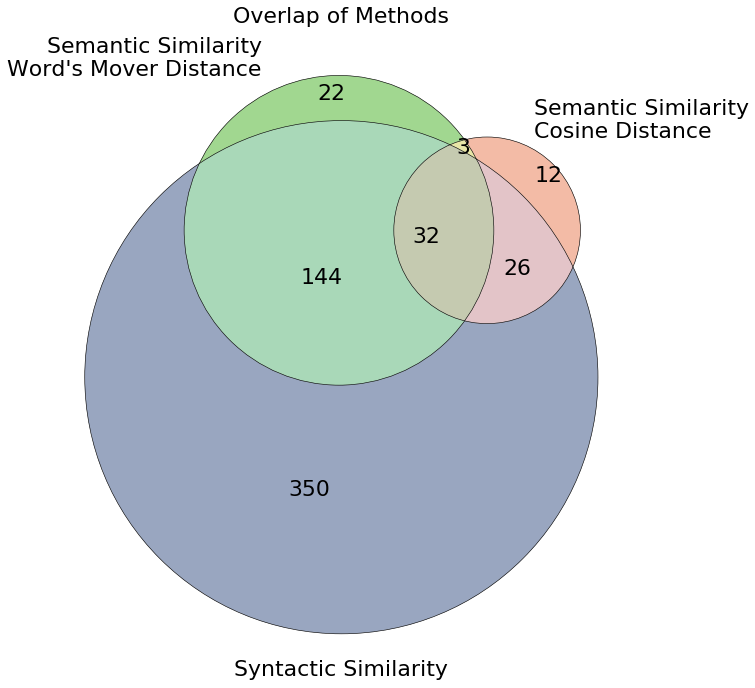

In [26]:
print(len(table['link'].unique())) #all the unique links found in all the methods
plt.figure(figsize=(16, 12))
v = venn3([set(groupA['link']), 
       set(groupB['link']),
      set(groupC['link'])], 
      set_labels = ("Semantic Similarity\nWord's Mover Distance", 'Semantic Similarity\nCosine Distance', 'Syntactic Similarity'),
      set_colors=('#44b023', '#e8784f', '#354e82'), alpha=0.5)
for text in v.set_labels:
    text.set_fontsize(22)
for text in v.subset_labels:
    text.set_fontsize(22)
c = venn3_circles([set(groupA['link']), 
       set(groupB['link']),
      set(groupC['link'])], linestyle='solid', linewidth=0.6)
plt.title("Overlap of Methods").set_fontsize(22)
#plt.savefig('../plots/venn-methods.png')
plt.savefig('../plots/venn-methods-0310.png')
plt.show()

---
## Creating the base citations graph (and positions)

In [27]:
nodes = df_to_json_nodes(df_relations = citations_subset_filtered,
                         df_attributes = sampled_cases[['case','source_case_topic']])
g = graph_and_layout(citations_subset_filtered, nodes) #the df of relations again
graph_description(g)

Nodes: 887
Edges: 1017
Avg Degree: 0.872173058013766


In [5]:
print(
len(sampled_cases[sampled_cases['source_case_topic']=='social policy']),
len(sampled_cases[sampled_cases['source_case_topic']=='public health']),
len(sampled_cases[sampled_cases['source_case_topic']=='data protection'])
)


85 63 29


In [28]:
def plot_graph(g, pos, groups, edges_groups):
    plt.figure(figsize=(18, 14))
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[0],
                           node_color="#878787", #gray
                           node_size=10,
                           linewidths = 3,
                           alpha=0.3)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[1],
                           node_color="black",## #black "social policy"
                           node_size=28, node_shape='^', linewidths=4,
                           alpha=0.85)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[2],
                           node_color="#9500ff", #purple  "public health"
                           node_size=28, node_shape='s', linewidths=3,
                           alpha=0.85)
    nx.draw_networkx_nodes(g,pos,
                           nodelist=groups[3],
                           node_color="#3ecc0e", #green "data protection"
                           node_size=28,linewidths=3,
                           alpha=0.85)
    nx.draw_networkx_edges(g,pos,
                           edgelist=edges_groups[0],
                           width=0.5,alpha=1, style='solid',connectionstyle='arc3', edge_color='gray')
    nx.draw_networkx_edges(g,pos,
                           edgelist=edges_groups[1],
                           width=1.8,alpha=1, style='solid', edge_color='#eb451c') #red

In [29]:
nodesDP = [x for x,y in g.nodes(data=True) if y['source_case_topic']=='data protection']
nodesPH = [x for x,y in g.nodes(data=True) if y['source_case_topic']=='public health']
nodesSP = [x for x,y in g.nodes(data=True) if y['source_case_topic']=='social policy']
nodesNA = [x for x,y in g.nodes(data=True) if y['source_case_topic']=='NA']

#rm.seed(550)
rm.seed(784)
positions = dict(zip(nodesDP,zip([rm.gauss(0.9, 0.2) for i in range(len(nodesDP))], #green "data protection"
                         [rm.gauss(0.95, 0.2) for i in range(len(nodesDP))])))
positions.update(dict(zip(nodesPH,zip([rm.gauss(-0.9, 0.25) for i in range(len(nodesSP))], #black "social policy"
                         [rm.gauss(0.9, 0.25) for i in range(len(nodesSP))]))))
positions.update(dict(zip(nodesSP,zip([rm.gauss(0, 0.1) for i in range(len(nodesPH))],  #purple  "public health"
                         [rm.gauss(-0.5, 0.05) for i in range(len(nodesPH))]))))
positions.update(dict(zip(nodesNA,zip([rm.gauss(0, 0.1) for i in range(len(nodesNA))],
                         [rm.gauss(0, 0.1) for i in range(len(nodesNA))]))))

In [30]:
# pos = nx.kamada_kawai_layout(g, dist=None,
#                         pos=positions,
#                         weight='weight',
#                         scale=1.2,
#                         center=None,
#                         dim=2)

pos = nx.spring_layout(g, dim=2, pos=positions, iterations=10, weight='weight', scale=1)

In [31]:
len(pos)

887

In [32]:
g_rest, g_SP, g_PH, g_DP = groups(g)

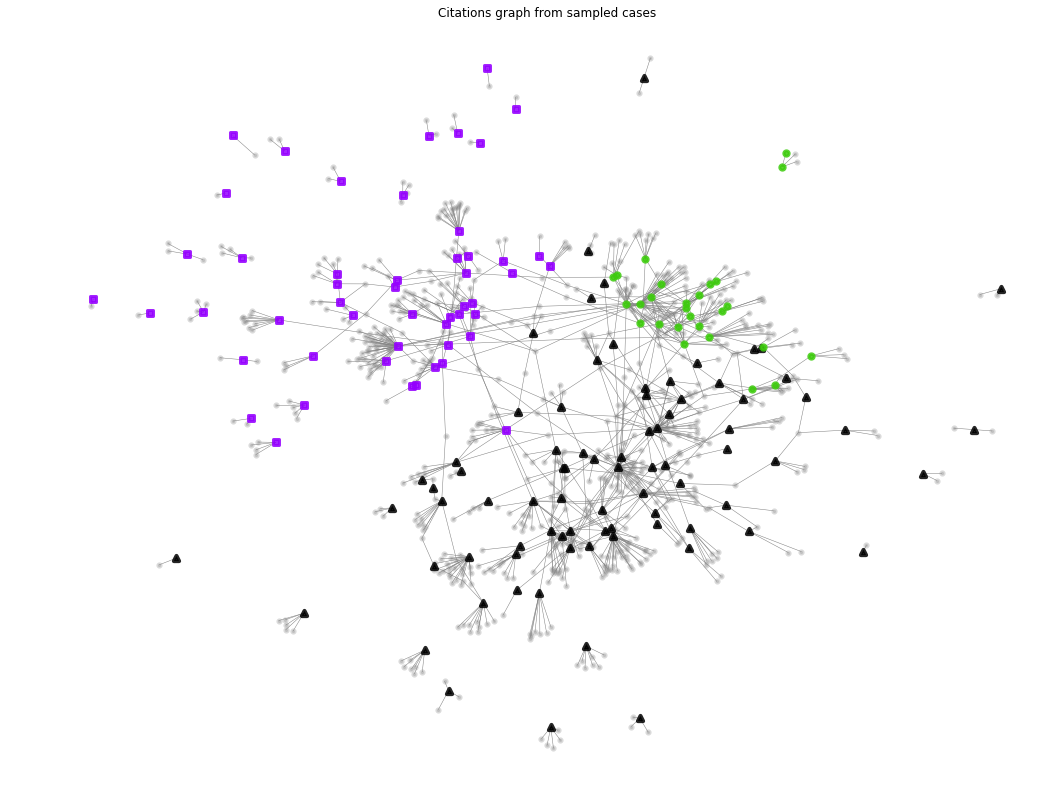

In [191]:
plot_graph(g,pos,
           [g_rest, g_SP, g_PH, g_DP],
           [[(s,t) for s, t, att in g.edges.data()],[]])
plt.axis('off')
plt.title('Citations graph from sampled cases')
plt.savefig('../plots/graph_base.png')
plt.show()

---
## Selecting one method at the time to analyse the overlap in venn diagram

In [34]:
mainmethods = ['tfidf-quintgram-nostem',
               'jaccard',
               'tfidf-nostem',
               'Law2Vec-200-WMD',
               'GoogleNews-300-WMD',
               'WMD_256_e30',
               'doc2vec_256_e30',
               'law2vec_200',
               'GoogleNews_300',
              'NoMethod']

In [171]:
method = mainmethods[8]
method_table = cases_similarity[cases_similarity['method'] == method]
print(method)

GoogleNews_300


In [172]:
print('Number of Similarity Relations: {}\nNumber of Citations Relations: {}'.format(len(set(method_table['link'])), 
                                                                                 len(set(citations_subset_filtered['link']))))

Number of Similarity Relations: 3540
Number of Citations Relations: 1068


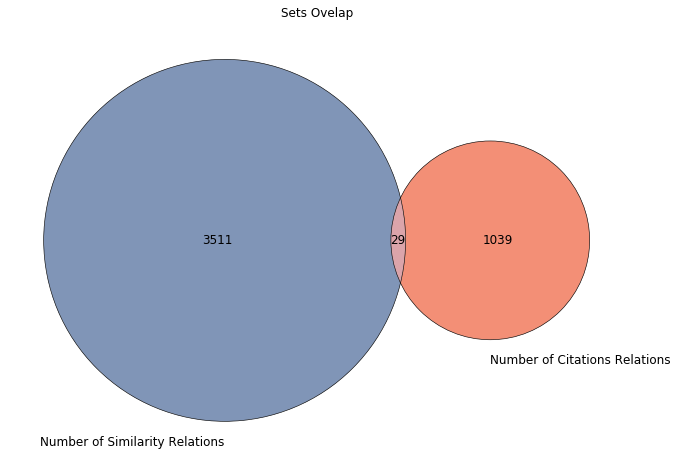

In [173]:
plt.figure(figsize=(12, 8))
v = venn2([set(method_table['link']),
           set(citations_subset_filtered['link'])],
           set_labels = ('Number of Similarity Relations', 'Number of Citations Relations'),
           set_colors=('#2d4f87', '#eb451c'), alpha=0.6)
for text in v.set_labels:
    text.set_fontsize(12)
for text in v.subset_labels:
    text.set_fontsize(12)
c = venn2_circles([set(method_table['link']), 
       set(citations_subset_filtered['link'])], linestyle='solid', linewidth=0.6)
plt.title("Sets Ovelap")
plt.savefig('../plots/venn-'+str(method)+'.png')
plt.show()


We want the overlap of the yellow with the green.  
If we merge both tables then 2 conditions will give me the overlap  

Finding what is outside the overlap so we add them to the dataset of similarity

In [174]:
list_citations_difference_ouside_overlap = \
    list(
    set(citations_subset_filtered.link)\
    - set(pd.merge(
    method_table, 
    citations_subset_filtered, 
    how='inner', 
    on='link')\
          ['link'].unique()))

In [175]:
citations_ouside_overlap = citations_subset_filtered[citations_subset_filtered['link']\
                        .isin(list_citations_difference_ouside_overlap)]\
                        .drop(columns=['link_type'])\
                        .reset_index(drop=True)

In [176]:
citations_ouside_overlap['method'] = 'NoMethod'
citations_ouside_overlap['citation_link'] = True
citations_ouside_overlap['similarity_link'] = False

In [177]:
len(citations_ouside_overlap)

1039

#### Cases universe

In [178]:
cases_universe = method_table.append(citations_ouside_overlap, ignore_index=True, sort=True)
models = pd.read_csv('../inputdata/models.csv')
cases_universe = pd.merge(cases_universe, models, how='left', on='method').reset_index(drop=True)   

In [179]:
cases_universe.tail()

,citation_link,link,method,similarity_link,source,source_case_topic,target,Similarity Type,Similarity Method,Model
4574,True,62009CJ0447-62016CJ0574,NoMethod,False,62009CJ0447,social policy,62016CJ0574,NoMethod,NoMethod,NoMethod
4575,True,62015CO0604-62018CO0780,NoMethod,False,62015CO0604,public health,62018CO0780,NoMethod,NoMethod,NoMethod
4576,True,62005CJ0326-62016CJ0244,NoMethod,False,62005CJ0326,public health,62016CJ0244,NoMethod,NoMethod,NoMethod
4577,True,62016CJ0384-62016CJ0203,NoMethod,False,62016CJ0384,public health,62016CJ0203,NoMethod,NoMethod,NoMethod
4578,True,61996CJ0416-62009CJ0070,NoMethod,False,61996CJ0416,social policy,62009CJ0070,NoMethod,NoMethod,NoMethod


---
## Intersection Graph

In [180]:
print(len(cases_universe))
cases_universe.head()

4579


,citation_link,link,method,similarity_link,source,source_case_topic,target,Similarity Type,Similarity Method,Model
0,False,62003CJ0453-62009CJ0266,GoogleNews_300,True,62003CJ0453,public health,62009CJ0266,Semantic,Cosine Similarity,GoogleNews Embeddings
1,False,62003CJ0453-62003CO0023,GoogleNews_300,True,62003CJ0453,public health,62003CO0023,Semantic,Cosine Similarity,GoogleNews Embeddings
2,False,62003CJ0453-62010CJ0309,GoogleNews_300,True,62003CJ0453,public health,62010CJ0309,Semantic,Cosine Similarity,GoogleNews Embeddings
3,False,62003CJ0453-62005CJ0266,GoogleNews_300,True,62003CJ0453,public health,62005CJ0266,Semantic,Cosine Similarity,GoogleNews Embeddings
4,False,62003CJ0453-62008CJ0211,GoogleNews_300,True,62003CJ0453,public health,62008CJ0211,Semantic,Cosine Similarity,GoogleNews Embeddings


In [181]:
#Filtering only the links from the citations universe
citations_set = cases_universe[cases_universe.citation_link==True]
len(citations_set)

1068

In [182]:
len(citations_set[citations_set.similarity_link==True])

29

In [183]:
overlap_rate = round(100*len(citations_set[citations_set.similarity_link==True])/len(citations_set),2)
print('Overlap!!: {}%'.format(overlap_rate))

Overlap!!: 2.72%


In [184]:
#citations_set.to_csv('../outputdata/methods/'+str(method)+'.csv')

---
#### Creating the intersection graph

In [185]:
nodesI = df_to_json_nodes(df_relations = citations_set,
                         df_attributes = citations_set.drop_duplicates(['source'], keep='first', inplace=False).drop(columns=['link']).reset_index(drop=True)
                         ,node_name = 'source')

gI = graph_and_layout(citations_set, nodesI) #the df of relations again
#pos3 = nx.spring_layout(g3)
#pos3 = nx.kamada_kawai_layout(g3)
graph_description(gI)

Nodes: 887
Edges: 1017
Avg Degree: 0.872173058013766


In [186]:
gI_rest, gI_SP, gI_PH, gI_DP = groups(gI)

edges_overlap = []
edges_rest = []
for s, t, att in gI.edges.data():
    if att['similarity_link'] == True:
        edges_overlap.append((s,t))
    else:
        edges_rest.append((s,t))
#print('Percentage of links overlap: ',len(edges_overlap)/len(gI.edges))

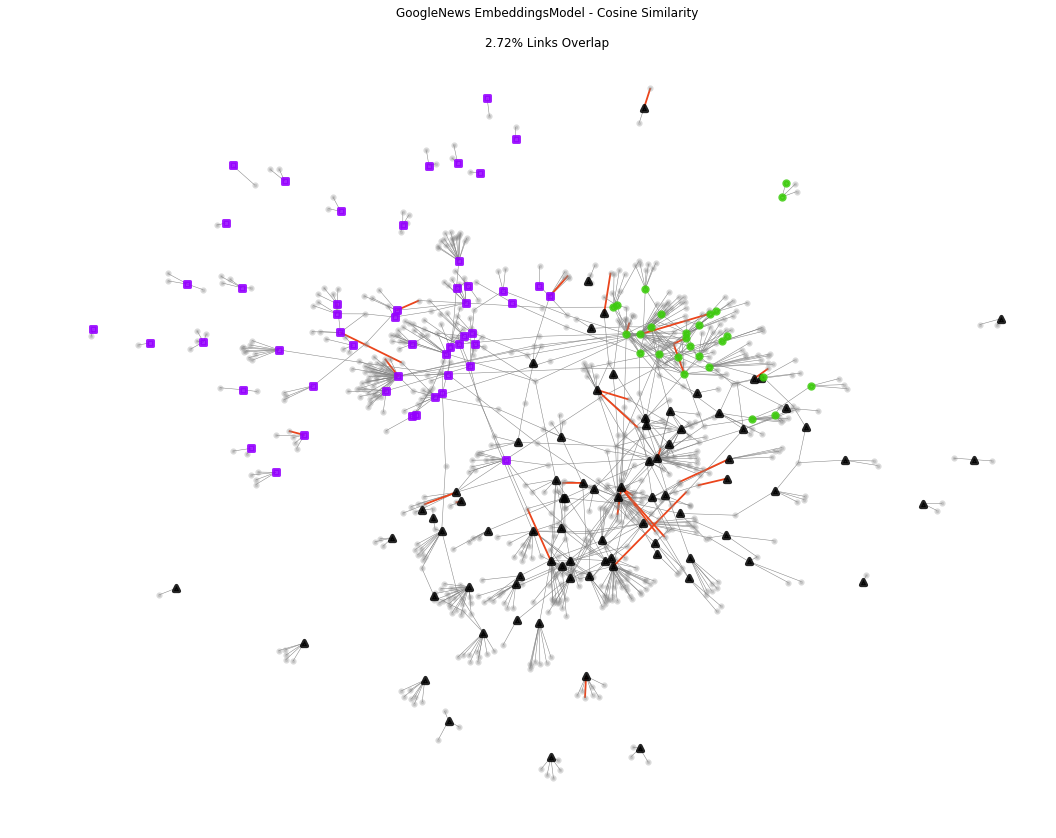

In [187]:
name = models[models['method'] == str(method)][['Model','Similarity Method']].values[0]
plot_graph(gI,pos,#pos3,
           [gI_rest, gI_SP, gI_PH, gI_DP],
           [edges_rest, edges_overlap])
plt.axis('off')
plt.title(str(name[0])+' Model - '+name[1]+'\n\n'+str(overlap_rate)+'% Links Overlap')
plt.savefig('../plots/graph-'+str(method)+'.png')
plt.show()